In [1]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/int/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'ticks']


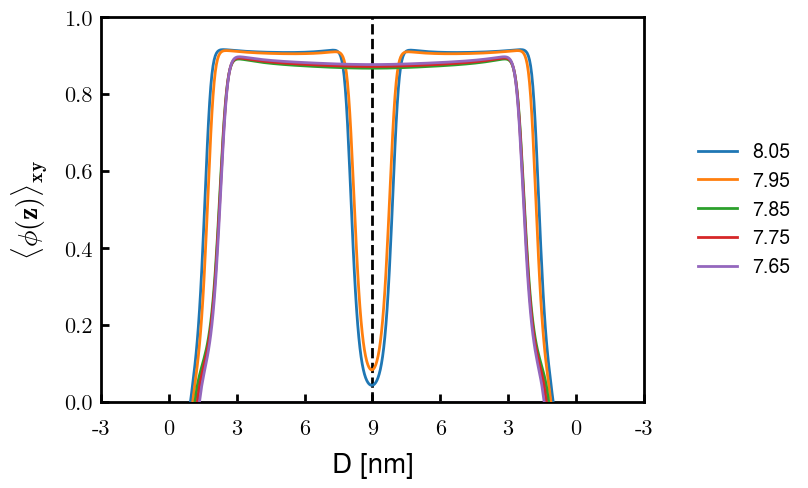

In [4]:
# SYSG Explore
labs = [8.05, 7.95, 7.85, 7.75, 7.65]
read_list = [GIT+'ph_a040d{:05.0f}.dat'.format(i*1000) for i in labs]
max_d = 9 #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 3 
plt.xlim(-step, step)
xrange = np.arange(-1*step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-1*step, max_d+0.1, step), np.arange(max_d-step, -1*(step+0.1), -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

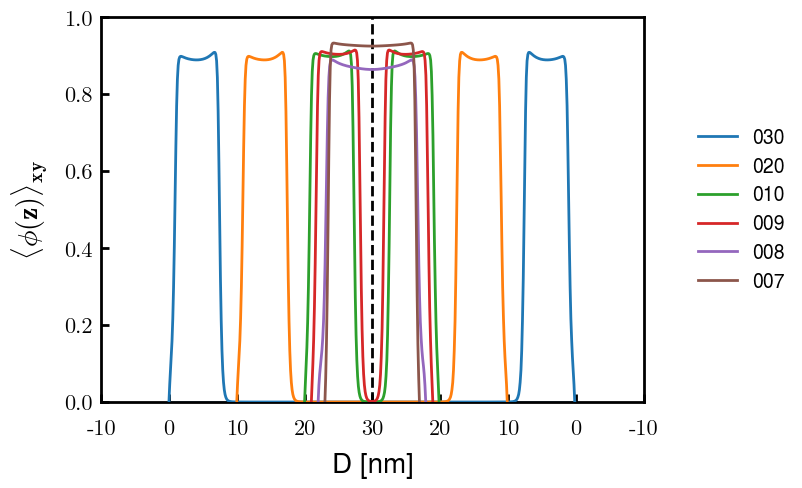

In [60]:
# SYSG 
labs = ['{:03d}'.format(i) for i in np.concatenate([np.arange(30, 9, -10),[9, 8,7]])]
read_list = [GIT+'ph_p1d{}.dat'.format(i) for i in labs]
# labs = ['{:03d}'.format(i) for i in np.concatenate([np.arange(50, 19, -10)])]
# read_list = [GIT+'ph_p2d{}.dat'.format(i) for i in labs]
max_d = 30 #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
block_Ni = [[5]]*len(read_list)
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)

plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 10
xrange = np.arange(-10, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-10, max_d+0.1, step), np.arange(max_d-step, -10.1, -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

In [30]:
dx = -0.025
F1 = 1.21982
F2 = 1.22206

print((F2-F1)/dx)

-0.08960000000000079


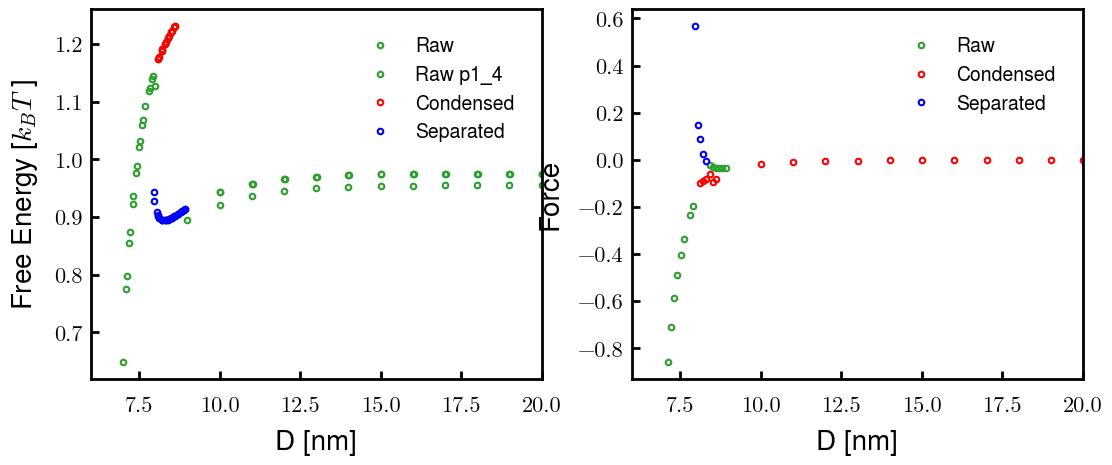

In [38]:
from scipy.interpolate import UnivariateSpline
freeE = pd.read_csv(GIT+'int_p1.txt', sep="\s+", skiprows=0, names = ['it', 'lx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='lx', ignore_index=True)
d, y = freeE.lx/2, freeE.freeE
freeE = pd.read_csv(GIT+'int_p12.txt', sep="\s+", skiprows=0, names = ['it', 'lx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='lx', ignore_index=True)
d2, y2 = freeE.lx/2, freeE.freeE
freeE = pd.read_csv(GIT+'p1_sep.txt', sep="\s+", skiprows=0, names = ['it', 'lx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='lx', ignore_index=True)
ds, ys = freeE.lx/2, freeE.freeE
freeE = pd.read_csv(GIT+'p1_con.txt', sep="\s+", skiprows=0, names = ['it', 'lx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='lx', ignore_index=True)
dc, yc = freeE.lx/2, freeE.freeE
max_d = max(d)
min_d = min(d)

## Raw Force Data
xf1 = [17.825/2, 17.625/2, 17.425/2, 17.225/2, 17.025/2, 16.825/2]  
yf1 = [-0.03572,  -0.0368, -0.03688, -0.03524, -0.03132, -0.02272] 
xf2 = [14.825/2, 14.625/2, 14.425/2, 14.225/2, 15.825/2, 15.625/2, 15.225/2, 15.025/2]
yf2 = [-0.4874,  -0.58656,   -0.708,  -0.8592,  -0.1972,  -0.2348,   -0.3372,-0.4052]
xc1 = [16.225/2, 16.425/2, 16.625/2, 16.825/2, 17.025/2, 17.225/2]
yc1 = [ -0.0988,  -0.0896,  -0.0820,  -0.0588, -0.09544,  -0.0812]
xs1 = [16.625/2, 16.425/2, 16.225/2, 16.125/2, 15.925/2] 
ys1 = [-0.00664,   0.0242,  0.08808,  0.14908,  0.56716]
xs2 = [40.025/2, 38.025/2, 36.025/2, 34.025/2, 32.025/2, 30.025/2, 28.025/2, 26.025/2, 24.025/2, 22.025/2, 20.025/2]
ys2 = [-4e-05, -8e-05, -1.6e-04, -3.2e-04, -5.6e-04, -1.04e-03, -1.84e-03, -3.332e-03, -6.04e-03, -1.056e-02, -1.932e-02]

## Cubic Splines Interpolater
d_new = np.linspace(min_d, max_d, 1000)
f = UnivariateSpline(d, y, s=1e-1, k=3)
csfit = f(d_new)
csder = f.derivative(n=1)(d_new)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
axs[0].plot(d, y, 'o', ms=4, markerfacecolor='none',  c='C2', label='Raw')
axs[0].plot(d2, y2, 'o', ms=4, markerfacecolor='none',  c='C2', label='Raw p1_4')
axs[0].plot(dc, yc, 'o', ms=4, markerfacecolor='none',  c='red', label='Condensed')
axs[0].plot(ds, ys, 'o', ms=4, markerfacecolor='none',  c='blue', label='Separated')
# axs[0].plot(d_new, csfit, c='C1', label='Cubic Spline')
axs[0].set_xlim(6,20)

axs[1].plot(xf1, yf1, 'o', ms=4, markerfacecolor='none', c='C2', label='Raw')
axs[1].plot(xf2, yf2, 'o', ms=4, markerfacecolor='none', c='C2', label='_Raw')
axs[1].plot(xc1, yc1, 'o', ms=4, markerfacecolor='none', c='red', label='Condensed')
axs[1].plot(xs1, ys1, 'o', ms=4, markerfacecolor='none', c='blue', label='Separated')
axs[1].plot(xs2, ys2, 'o', ms=4, markerfacecolor='none', c='red', label='_Condensed')
# axs[1].plot(d_new, csder, c='C1', label='Cubic Spline Der')
axs[1].set_xlim(6,20)

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

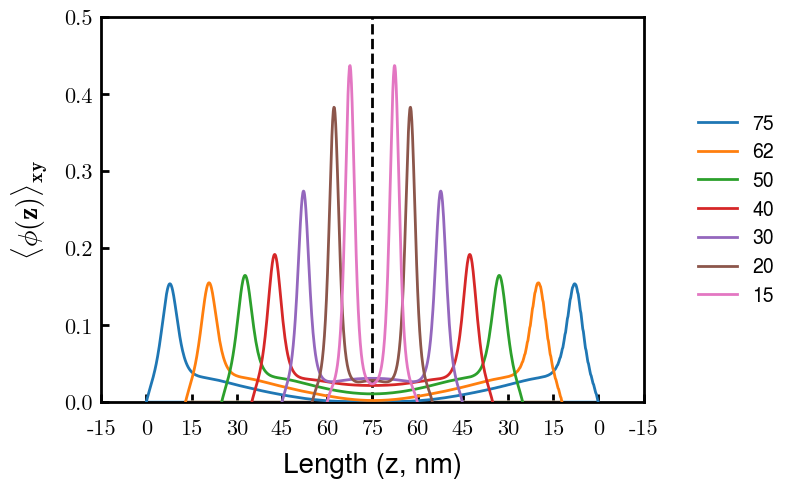

In [33]:
# NFH
labs = [75, 62, 50, 40, 30, 20, 15]
# labs = [40, 30, 25, 20, 15]
read_list = [GIT+'ph_H04d{:03d}.dat'.format(i) for i in labs]
max_d = 75 #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=0.50, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 15
plt.xlim(-step, step)
xrange = np.arange(-1*step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-1*step, max_d+0.1, step), np.arange(max_d-step, -1*(step+0.1), -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

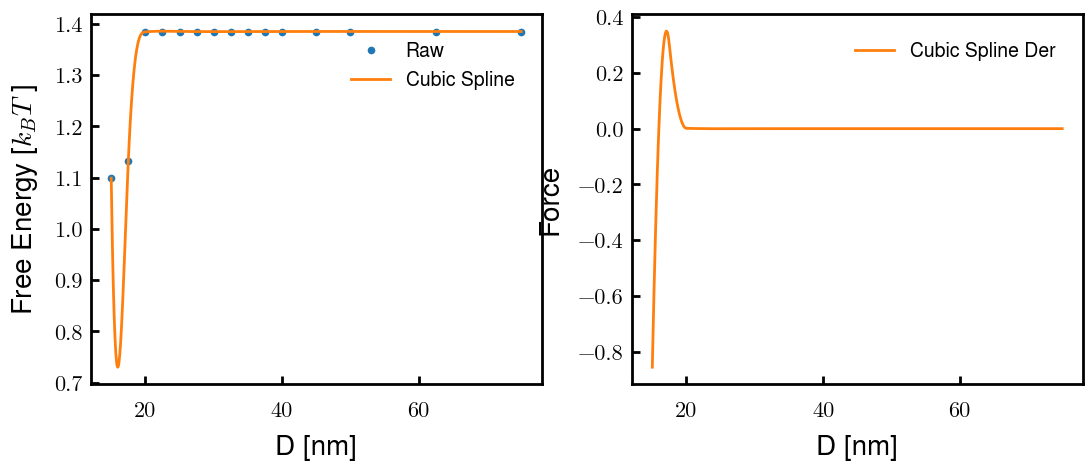

In [23]:
from scipy.interpolate import UnivariateSpline
freeE = pd.read_csv(GIT+'NFH_04.txt', sep="\s+", skiprows=0, names = ['it', 'lx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='lx', ignore_index=True)
d, y = freeE.lx/2, freeE.freeE
max_d = max(d)
min_d = min(d)

## Centered Finite Difference 
# dx  = d.iloc[:-1]  - d.iloc[1:].reset_index(drop=True)
# dxc = (d.iloc[:-1] + d.iloc[1:].reset_index(drop=True)) / 2
# dyc = y.iloc[:-1] - y.iloc[1:].reset_index(drop=True)
# dyc = np.divide(dyc, dx)

## Cubic Splines Interpolater
d_new = np.linspace(min_d, max_d, 1000)
f = UnivariateSpline(d, y, s=1e-6, k=3)
csfit = f(d_new)
csder = f.derivative(n=1)(d_new)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
axs[0].plot(d, y, 'o',   c='C0', label='Raw', ms=4)
axs[0].plot(d_new, csfit, c='C1', label='Cubic Spline')

# axs[1].plot(dxc[0:], dyc[0:], 'o', c='C0', label='Raw cFD',alpha=0.7)
axs[1].plot(d_new, csder,   c='C1', label='Cubic Spline Der')

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

In [28]:
filename = 'W_a040c010_x175s002.dat' #Nx = 75, dx = 17.0/150
new_Lx = 90
N = round(new_Lx * 150/17.0)

names = ['*', '1','2','3','4','5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)

if N > 2*len(df.index): 
    rem = ['['] + [1.00]*5 + [']'] + [-1.00]*2 + [0.00]
    rem = pd.DataFrame([rem for i in range(N-2*len(df.index))], columns=names)
    new = pd.concat([df, rem, df.iloc[::-1]], ignore_index=True)
else: 
    shave = df.iloc[:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]])
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    new.to_csv('./imgs/W_sym{}.dat'.format(new_Lx), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))

Success: 794 == 794.
